In [1]:
# =============================================================================
# 1. IMPORTS AND CONFIGURATION
# =============================================================================
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from transformers import AutoModel
from timm import create_model
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
from tqdm import tqdm
import os
from collections import OrderedDict
import seaborn as sns
import matplotlib.pyplot as plt

# --- Main Configuration ---
config = {
    'base_dir': r'A:\Speech Journal\melspectrograms_dataset',
    'batch_size': 16,
    'img_size': 224,
    'num_workers': 0,

    # --- Model Names (Corrected) ---
    'dino_model_name': 'facebook/dinov3-convnext-tiny-pretrain-lvd1689m', # Correct Hugging Face ID
    'eva_model_name': 'eva02_tiny_patch14_224.mim_in22k',
    'maxvit_model_name': 'maxvit_tiny_tf_224.in1k',

    # --- Model Paths (Ensure these are correct) ---
    'dino_model_path': r'A:\Speech Journal\v3 dinov3\best_finetuned_model.pth',
    'eva_model_path': r'A:\Speech Journal\V5 Eva02\best_finetuned_model.pth',
    'maxvit_model_path': r'A:\Speech Journal\v6 maxVit\best_full_model.pth',
}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# =============================================================================
# 2. MODEL WRAPPER AND HELPER DEFINITIONS
# =============================================================================

# Wrapper for the Hugging Face DinoV3 model
class TransformersClassifier(nn.Module):
    def __init__(self, model_name, num_classes, drop_rate=0.0):
        super().__init__()
        self.backbone = AutoModel.from_pretrained(model_name)
        feature_dim = self.backbone.config.hidden_sizes[-1]
        self.classifier = nn.Sequential(
            nn.Linear(feature_dim, 512), nn.BatchNorm1d(512), nn.GELU(),
            nn.Dropout(drop_rate), nn.Linear(512, num_classes)
        )
    def forward(self, x):
        outputs = self.backbone(pixel_values=x)
        features = torch.mean(outputs.last_hidden_state, dim=1)
        return self.classifier(features)

# Wrapper for the timm MaxViT model
class TimmClassifier(nn.Module):
    def __init__(self, model_name, num_classes, drop_rate=0.0):
        super().__init__()
        self.backbone = create_model(model_name, pretrained=False, num_classes=0)
        feature_dim = self.backbone.num_features
        self.classifier = nn.Sequential(
            nn.Linear(feature_dim, 512), nn.BatchNorm1d(512), nn.GELU(),
            nn.Dropout(drop_rate), nn.Linear(512, num_classes)
        )
    def forward(self, x):
        return self.classifier(self.backbone(x))

def get_data_loaders(base_dir, img_size, batch_size, num_workers):
    data_transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    val_dataset = datasets.ImageFolder(root=os.path.join(base_dir, 'validation'), transform=data_transform)
    test_dataset = datasets.ImageFolder(root=os.path.join(base_dir, 'test'), transform=data_transform)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
    print(f"Found {len(val_dataset)} validation and {len(test_dataset)} test images.")
    return val_loader, test_loader, test_dataset.classes

def load_model_weights(model, path, device):
    """Robustly loads weights from a checkpoint dict or a direct state_dict."""
    checkpoint = torch.load(path, map_location=device)
    state_dict = checkpoint.get('model_state_dict', checkpoint)
    model.load_state_dict(state_dict)
    print(f"✅ Loaded weights for {model.__class__.__name__} from: {os.path.basename(path)}")

# =============================================================================
# 3. TEMPERATURE SCALING AND BOOSTED VOTING FUNCTIONS
# =============================================================================

class ModelWithTemperature(nn.Module):
    def __init__(self, model):
        super(ModelWithTemperature, self).__init__()
        self.model = model
        self.temperature = nn.Parameter(torch.ones(1) * 1.5)
    def forward(self, input):
        return self.temperature_scale(self.model(input))
    def temperature_scale(self, logits):
        return logits / self.temperature

def find_optimal_temperature(model, val_loader, device):
    model.eval()
    scaled_model = ModelWithTemperature(model).to(device)
    nll_criterion = nn.CrossEntropyLoss().to(device)
    optimizer = optim.LBFGS([scaled_model.temperature], lr=0.01, max_iter=50)
    def eval_closure():
        optimizer.zero_grad()
        with torch.no_grad():
            all_logits, all_labels = [], []
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                all_logits.append(model(inputs))
                all_labels.append(labels)
            all_logits, all_labels = torch.cat(all_logits), torch.cat(all_labels)
        scaled_logits = scaled_model.temperature_scale(all_logits)
        loss = nll_criterion(scaled_logits, all_labels)
        loss.backward()
        return loss
    optimizer.step(eval_closure)
    return scaled_model.temperature.item()

def boosted_weighted_voting(models, temperatures, val_loader, test_loader, class_names):
    """Performs a weighted vote where weights are learned from the validation set."""
    print("\n" + "="*60 + "\nBOOSTED WEIGHTED VOTING\n" + "="*60)
    
    # Calculate model weights based on validation accuracy
    print("Calculating base model weights on validation set...")
    base_weights = []
    
    with torch.no_grad():
        for model, temp in zip(models, temperatures):
            correct, total = 0, 0
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                preds = (model(images) / temp).argmax(dim=1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)
            
            acc = correct / total
            # AdaBoost-like weight formula
            weight = 0.5 * np.log((acc + 1e-10) / (1 - acc + 1e-10))
            base_weights.append(weight)
    
    base_weights = np.array(base_weights)
    base_weights = np.maximum(base_weights, 0) # Ensure weights are non-negative
    
    print("Learned model weights:")
    for name, w in zip(['DinoV3', 'EVA-02', 'MaxViT'], base_weights):
        print(f"  {name}: {w:.4f}")
    
    # Apply weighted voting on the test set
    all_labels, final_preds = [], []
    
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Boosted Voting"):
            images = images.to(device)
            
            all_probs = torch.stack([F.softmax(model(images) / temp, dim=1) for model, temp in zip(models, temperatures)])
            
            # Apply learned weights to the probabilities
            weighted_probs = torch.zeros_like(all_probs[0])
            for i in range(len(models)):
                weighted_probs += base_weights[i] * all_probs[i]
            
            preds = weighted_probs.argmax(dim=1)
            final_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
    return all_labels, final_preds

# =============================================================================
# 4. MAIN EXECUTION SCRIPT
# =============================================================================

if __name__ == "__main__":
    val_loader, test_loader, class_names = get_data_loaders(
        config['base_dir'], config['img_size'], config['batch_size'], config['num_workers']
    )
    num_classes = len(class_names)

    print("\n--- Loading Models With Correct Architectures ---")
    model_dino = TransformersClassifier(config['dino_model_name'], num_classes).to(device)
    load_model_weights(model_dino, config['dino_model_path'], device)

    model_eva = create_model(config['eva_model_name'], pretrained=False, num_classes=num_classes).to(device)
    load_model_weights(model_eva, config['eva_model_path'], device)

    model_maxvit = TimmClassifier(config['maxvit_model_name'], num_classes).to(device)
    load_model_weights(model_maxvit, config['maxvit_model_path'], device)

    models = [model_dino, model_eva, model_maxvit]

    print("\n--- Calibrating Models ---")
    optimal_temperatures = [find_optimal_temperature(model, val_loader, device) for model in models]
    print(f"Final Optimal Temperatures (Dino, EVA, MaxViT): {[f'{t:.3f}' for t in optimal_temperatures]}")
    
    # --- Run and Evaluate the Ensemble ---
    final_labels, final_preds = boosted_weighted_voting(models, optimal_temperatures, val_loader, test_loader, class_names)

    # --- Print Final Report ---
    print("\n" + "="*60 + "\nFINAL ENSEMBLE PERFORMANCE\n" + "="*60)
    accuracy = accuracy_score(final_labels, final_preds)
    print(f"Overall Accuracy: {accuracy:.4f} ({accuracy:.2%})")
    
    print("\nClassification Report:")
    print(classification_report(final_labels, final_preds, target_names=class_names, digits=4))

Using device: cuda
Found 73 validation and 74 test images.

--- Loading Models With Correct Architectures ---
✅ Loaded weights for TransformersClassifier from: best_finetuned_model.pth
✅ Loaded weights for Eva from: best_finetuned_model.pth
✅ Loaded weights for TimmClassifier from: best_full_model.pth

--- Calibrating Models ---
Final Optimal Temperatures (Dino, EVA, MaxViT): ['1.304', '1.328', '1.091']

BOOSTED WEIGHTED VOTING
Calculating base model weights on validation set...
Learned model weights:
  DinoV3: 1.3050
  EVA-02: 0.8646
  MaxViT: 0.9808


Boosted Voting: 100%|██████████| 5/5 [00:01<00:00,  4.40it/s]


FINAL ENSEMBLE PERFORMANCE
Overall Accuracy: 0.8649 (86.49%)

Classification Report:
                        precision    recall  f1-score   support

             Dysarthia     1.0000    1.0000    1.0000        13
            Laryngitis     0.6923    0.6923    0.6923        13
           Laryngozele     0.7500    1.0000    0.8571         9
           Vox senilis     0.9167    0.8462    0.8800        13
             parkinson     1.0000    1.0000    1.0000        13
spasmodische_dysphonie     0.8182    0.6923    0.7500        13

              accuracy                         0.8649        74
             macro avg     0.8629    0.8718    0.8632        74
          weighted avg     0.8690    0.8649    0.8636        74



In [3]:
# =============================================================================
# 1. IMPORTS AND CONFIGURATION
# =============================================================================
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from transformers import AutoModel
from timm import create_model
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
from tqdm import tqdm
import os

# --- Main Configuration ---
config = {
    'base_dir': r'A:\Speech Journal\melspectrograms_dataset',
    'batch_size': 16,
    'img_size': 224,
    'num_workers': 0,

    # --- Model Names ---
    'dino_model_name': 'facebook/dinov3-convnext-tiny-pretrain-lvd1689m',
    'eva_model_name': 'eva02_tiny_patch14_224.mim_in22k',
    'maxvit_model_name': 'maxvit_tiny_tf_224.in1k',

    # --- Model Paths ---
    'dino_model_path': r'A:\Speech Journal\v3 dinov3\best_finetuned_model.pth',
    'eva_model_path': r'A:\Speech Journal\V5 Eva02\best_finetuned_model.pth',
    'maxvit_model_path': r'A:\Speech Journal\v6 maxVit\best_full_model.pth',
}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# =============================================================================
# 2. MODEL WRAPPER AND HELPER DEFINITIONS
# =============================================================================

# Wrapper for the Hugging Face DinoV3 model
class TransformersClassifier(nn.Module):
    def __init__(self, model_name, num_classes, drop_rate=0.0):
        super().__init__()
        self.backbone = AutoModel.from_pretrained(model_name)
        feature_dim = self.backbone.config.hidden_sizes[-1]
        self.classifier = nn.Sequential(
            nn.Linear(feature_dim, 512), nn.BatchNorm1d(512), nn.GELU(),
            nn.Dropout(drop_rate), nn.Linear(512, num_classes)
        )
    def forward(self, x):
        outputs = self.backbone(pixel_values=x)
        features = torch.mean(outputs.last_hidden_state, dim=1)
        return self.classifier(features)

# Wrapper for the timm MaxViT model
class TimmClassifier(nn.Module):
    def __init__(self, model_name, num_classes, drop_rate=0.0):
        super().__init__()
        self.backbone = create_model(model_name, pretrained=False, num_classes=0)
        feature_dim = self.backbone.num_features
        self.classifier = nn.Sequential(
            nn.Linear(feature_dim, 512), nn.BatchNorm1d(512), nn.GELU(),
            nn.Dropout(drop_rate), nn.Linear(512, num_classes)
        )
    def forward(self, x):
        return self.classifier(self.backbone(x))

def get_data_loaders(base_dir, img_size, batch_size, num_workers):
    data_transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    val_dataset = datasets.ImageFolder(root=os.path.join(base_dir, 'validation'), transform=data_transform)
    test_dataset = datasets.ImageFolder(root=os.path.join(base_dir, 'test'), transform=data_transform)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
    print(f"Found {len(val_dataset)} validation and {len(test_dataset)} test images.")
    return val_loader, test_loader, test_dataset.classes

def load_model_weights(model, path, device):
    """Robustly loads weights from a checkpoint dict or a direct state_dict."""
    checkpoint = torch.load(path, map_location=device)
    state_dict = checkpoint.get('model_state_dict', checkpoint)
    model.load_state_dict(state_dict)
    print(f"✅ Loaded weights for {model.__class__.__name__} from: {os.path.basename(path)}")

# =============================================================================
# 3. TEMPERATURE SCALING AND BOOSTED VOTING FUNCTIONS
# =============================================================================

class ModelWithTemperature(nn.Module):
    def __init__(self, model):
        super(ModelWithTemperature, self).__init__()
        self.model = model
        self.temperature = nn.Parameter(torch.ones(1) * 1.5)
    def forward(self, input):
        return self.temperature_scale(self.model(input))
    def temperature_scale(self, logits):
        return logits / self.temperature

def find_optimal_temperature(model, val_loader, device):
    model.eval()
    scaled_model = ModelWithTemperature(model).to(device)
    nll_criterion = nn.CrossEntropyLoss().to(device)
    optimizer = optim.LBFGS([scaled_model.temperature], lr=0.01, max_iter=50)
    def eval_closure():
        optimizer.zero_grad()
        with torch.no_grad():
            all_logits, all_labels = [], []
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                all_logits.append(model(inputs))
                all_labels.append(labels)
            all_logits, all_labels = torch.cat(all_logits), torch.cat(all_labels)
        scaled_logits = scaled_model.temperature_scale(all_logits)
        loss = nll_criterion(scaled_logits, all_labels)
        loss.backward()
        return loss
    optimizer.step(eval_closure)
    return scaled_model.temperature.item()

def boosted_weighted_voting(models, temperatures, val_loader, test_loader, class_names):
    """Performs a weighted vote where weights are learned from the validation set."""
    print("\n" + "="*60 + "\nBOOSTED WEIGHTED VOTING\n" + "="*60)
    
    # Calculate model weights based on validation accuracy
    print("Calculating base model weights on validation set...")
    base_weights = []
    
    with torch.no_grad():
        for model, temp in zip(models, temperatures):
            model.eval() # Ensure model is in eval mode
            correct, total = 0, 0
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                # Apply temperature scaling before finding the max
                preds = (model(images) / temp).argmax(dim=1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)
            
            acc = correct / total
            # AdaBoost-like weight formula, with epsilon for stability
            weight = 0.5 * np.log((acc + 1e-10) / (1 - acc + 1e-10))
            base_weights.append(weight)
    
    base_weights = np.array(base_weights)
    base_weights = np.maximum(base_weights, 0) # Ensure weights are non-negative
    
    print("Learned model weights:")
    for name, w in zip(['DinoV3', 'EVA-02', 'MaxViT'], base_weights):
        print(f"  {name}: {w:.4f}")
    
    # Apply weighted voting on the test set
    all_labels, final_preds = [], []
    
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Boosted Voting"):
            images = images.to(device)
            
            # Stack probabilities from each model after applying temperature scaling
            all_probs = torch.stack([F.softmax(model(images) / temp, dim=1) for model, temp in zip(models, temperatures)])
            
            # Apply learned weights to the probabilities
            weighted_probs = torch.zeros_like(all_probs[0])
            for i in range(len(models)):
                weighted_probs += base_weights[i] * all_probs[i]
            
            preds = weighted_probs.argmax(dim=1)
            final_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
    return all_labels, final_preds

# =============================================================================
# 4. MAIN EXECUTION SCRIPT
# =============================================================================

if __name__ == "__main__":
    val_loader, test_loader, class_names = get_data_loaders(
        config['base_dir'], config['img_size'], config['batch_size'], config['num_workers']
    )
    num_classes = len(class_names)

    print("\n--- Loading Models With Correct Architectures ---")
    model_dino = TransformersClassifier(config['dino_model_name'], num_classes).to(device)
    load_model_weights(model_dino, config['dino_model_path'], device)

    model_eva = create_model(config['eva_model_name'], pretrained=False, num_classes=num_classes).to(device)
    load_model_weights(model_eva, config['eva_model_path'], device)

    model_maxvit = TimmClassifier(config['maxvit_model_name'], num_classes).to(device)
    load_model_weights(model_maxvit, config['maxvit_model_path'], device)

    models = [model_dino, model_eva, model_maxvit]

    # --- 1. Original Run with Temperature Scaling ---
    print("\n--- Calibrating Models (Original Run) ---")
    optimal_temperatures = [find_optimal_temperature(model, val_loader, device) for model in models]
    print(f"Final Optimal Temperatures (Dino, EVA, MaxViT): {[f'{t:.3f}' for t in optimal_temperatures]}")
    
    final_labels, final_preds = boosted_weighted_voting(models, optimal_temperatures, val_loader, test_loader, class_names)

    print("\n" + "="*60 + "\nFINAL ENSEMBLE PERFORMANCE (WITH TEMPERATURE SCALING)\n" + "="*60)
    accuracy = accuracy_score(final_labels, final_preds)
    print(f"Overall Accuracy: {accuracy:.4f} ({accuracy:.2%})")
    print("\nClassification Report:")
    print(classification_report(final_labels, final_preds, target_names=class_names, digits=4))

    print("\n\n" + "#"*70)
    print("### STARTING ABLATION STUDY: ENSEMBLE WITHOUT TEMPERATURE SCALING ###")
    print("#"*70 + "\n")

    # --- 2. Ablation Study without Temperature Scaling ---
    # To disable temperature scaling, we simply set all temperatures to 1.0
    no_temperatures = [1.0] * len(models)
    print(f"Using fixed temperatures for ablation: {no_temperatures}")
    
    # Run the same voting function, but with temperatures set to 1.0
    abl_labels, abl_preds = boosted_weighted_voting(models, no_temperatures, val_loader, test_loader, class_names)

    # --- Print Final Ablation Report ---
    print("\n" + "="*60 + "\nABLATION ENSEMBLE PERFORMANCE (WITHOUT TEMPERATURE SCALING)\n" + "="*60)
    abl_accuracy = accuracy_score(abl_labels, abl_preds)
    print(f"Overall Accuracy: {abl_accuracy:.4f} ({abl_accuracy:.2%})")
    print("\nClassification Report:")
    print(classification_report(abl_labels, abl_preds, target_names=class_names, digits=4))

Using device: cuda
Found 73 validation and 74 test images.

--- Loading Models With Correct Architectures ---
✅ Loaded weights for TransformersClassifier from: best_finetuned_model.pth
✅ Loaded weights for Eva from: best_finetuned_model.pth
✅ Loaded weights for TimmClassifier from: best_full_model.pth

--- Calibrating Models (Original Run) ---
Final Optimal Temperatures (Dino, EVA, MaxViT): ['1.304', '1.328', '1.091']

BOOSTED WEIGHTED VOTING
Calculating base model weights on validation set...
Learned model weights:
  DinoV3: 1.3050
  EVA-02: 0.8646
  MaxViT: 0.9808


Boosted Voting: 100%|██████████| 5/5 [00:01<00:00,  4.05it/s]



FINAL ENSEMBLE PERFORMANCE (WITH TEMPERATURE SCALING)
Overall Accuracy: 0.8649 (86.49%)

Classification Report:
                        precision    recall  f1-score   support

             Dysarthia     1.0000    1.0000    1.0000        13
            Laryngitis     0.6923    0.6923    0.6923        13
           Laryngozele     0.7500    1.0000    0.8571         9
           Vox senilis     0.9167    0.8462    0.8800        13
             parkinson     1.0000    1.0000    1.0000        13
spasmodische_dysphonie     0.8182    0.6923    0.7500        13

              accuracy                         0.8649        74
             macro avg     0.8629    0.8718    0.8632        74
          weighted avg     0.8690    0.8649    0.8636        74



######################################################################
### STARTING ABLATION STUDY: ENSEMBLE WITHOUT TEMPERATURE SCALING ###
######################################################################

Using fixed temperatures for 

Boosted Voting: 100%|██████████| 5/5 [00:01<00:00,  3.89it/s]


ABLATION ENSEMBLE PERFORMANCE (WITHOUT TEMPERATURE SCALING)
Overall Accuracy: 0.8514 (85.14%)

Classification Report:
                        precision    recall  f1-score   support

             Dysarthia     1.0000    1.0000    1.0000        13
            Laryngitis     0.6429    0.6923    0.6667        13
           Laryngozele     0.7500    1.0000    0.8571         9
           Vox senilis     0.9167    0.8462    0.8800        13
             parkinson     1.0000    1.0000    1.0000        13
spasmodische_dysphonie     0.8000    0.6154    0.6957        13

              accuracy                         0.8514        74
             macro avg     0.8516    0.8590    0.8499        74
          weighted avg     0.8571    0.8514    0.8495        74



In [2]:
# =============================================================================
# 1. IMPORTS AND CONFIGURATION
# =============================================================================
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from transformers import AutoModel
from timm import create_model
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
from tqdm import tqdm
import os
import warnings

warnings.filterwarnings("ignore", category=UserWarning)

# --- Main Configuration ---
config = {
    'base_dir': r'A:\Speech Journal\melspectrograms_dataset',
    'batch_size': 16,
    'img_size': 224,
    'num_workers': 0,

    # --- Model Names ---
    'dino_model_name': 'facebook/dinov3-convnext-tiny-pretrain-lvd1689m',
    'eva_model_name': 'eva02_tiny_patch14_224.mim_in22k',
    'maxvit_model_name': 'maxvit_tiny_tf_224.in1k',

    # --- Model Paths (Ensure these are correct) ---
    'dino_model_path': r'A:\Speech Journal\v3 dinov3\best_finetuned_model.pth',
    'eva_model_path': r'A:\Speech Journal\V5 Eva02\best_finetuned_model.pth',
    'maxvit_model_path': r'A:\Speech Journal\v6 maxVit\best_full_model.pth',
}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# =============================================================================
# 2. MODEL WRAPPERS AND HELPERS
# =============================================================================

class TransformersClassifier(nn.Module):
    def __init__(self, model_name, num_classes, drop_rate=0.0):
        super().__init__()
        self.backbone = AutoModel.from_pretrained(model_name)
        feature_dim = self.backbone.config.hidden_sizes[-1]
        self.classifier = nn.Sequential(
            nn.Linear(feature_dim, 512), nn.BatchNorm1d(512),
            nn.GELU(), nn.Dropout(drop_rate), nn.Linear(512, num_classes)
        )
    def forward(self, x):
        outputs = self.backbone(pixel_values=x)
        features = torch.mean(outputs.last_hidden_state, dim=1)
        return self.classifier(features)

class TimmClassifier(nn.Module):
    def __init__(self, model_name, num_classes, drop_rate=0.0):
        super().__init__()
        self.backbone = create_model(model_name, pretrained=False, num_classes=0)
        feature_dim = self.backbone.num_features
        self.classifier = nn.Sequential(
            nn.Linear(feature_dim, 512), nn.BatchNorm1d(512),
            nn.GELU(), nn.Dropout(drop_rate), nn.Linear(512, num_classes)
        )
    def forward(self, x):
        return self.classifier(self.backbone(x))

def get_data_loaders(base_dir, img_size, batch_size, num_workers):
    # CORRECTED: Reverted to default interpolation to match the 86.49% result
    data_transform = transforms.Compose([
        transforms.Resize((img_size, img_size)), # Uses default BILINEAR interpolation
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    val_dataset = datasets.ImageFolder(root=os.path.join(base_dir, 'validation'), transform=data_transform)
    test_dataset = datasets.ImageFolder(root=os.path.join(base_dir, 'test'), transform=data_transform)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
    print(f"Found {len(val_dataset)} validation and {len(test_dataset)} test images.")
    return val_loader, test_loader, test_dataset.classes

def load_model_weights(model, path, device):
    checkpoint = torch.load(path, map_location=device)
    state_dict = checkpoint.get('model_state_dict', checkpoint)
    model.load_state_dict(state_dict)
    print(f"✅ Loaded weights for '{model.__class__.__name__}' from: {os.path.basename(path)}")

# =============================================================================
# 3. PEAK-PERFORMANCE ENSEMBLE METHOD
# =============================================================================

def boosted_weighted_voting(models, model_names, val_loader, test_loader, device, use_tta=True):
    """
    Calculates weights based on validation accuracy and applies them to an
    ensemble prediction, with an option for Test-Time Augmentation (TTA).
    """
    method_name = "Boosted Voting" + (" with TTA" if use_tta else " (No TTA)")
    if len(models) == 1:
        method_name = f"{model_names[0]} (Single Model)"
    print("\n" + "="*70 + f"\nRUNNING: {method_name}\n" + "="*70)
    
    base_weights = []
    print("Calculating model weights based on validation accuracy...")
    with torch.no_grad():
        for model in models:
            correct, total = 0, 0
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                preds = model(images).argmax(dim=1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)
            acc = correct / total
            weight = 0.5 * np.log((acc + 1e-10) / (1 - acc + 1e-10))
            base_weights.append(weight)
            
    base_weights = np.maximum(np.array(base_weights), 0)
    if len(models) > 1:
        print("Calculated weights:")
        for name, w in zip(model_names, base_weights):
            print(f"  {name:<10}: {w:.4f}")

    all_labels, final_preds = [], []
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc=f"Predicting"):
            images = images.to(device)
            
            probs_orig = torch.stack([F.softmax(model(images), dim=1) for model in models])
            
            if use_tta:
                images_flipped = torch.flip(images, dims=[3])
                probs_flipped = torch.stack([F.softmax(model(images_flipped), dim=1) for model in models])
                all_probs = (probs_orig + probs_flipped) / 2.0
            else:
                all_probs = probs_orig

            weighted_probs = torch.einsum('m,mbc->bc', torch.tensor(base_weights, device=device, dtype=torch.float), all_probs)
            preds = weighted_probs.argmax(dim=1)
            
            final_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
    return all_labels, final_preds

# =============================================================================
# 4. MAIN EXECUTION & ABLATION STUDY
# =============================================================================

if __name__ == "__main__":
    val_loader, test_loader, class_names = get_data_loaders(
        config['base_dir'], config['img_size'], config['batch_size'], config['num_workers']
    )
    num_classes = len(class_names)

    print("\n--- Loading All Models ---")
    model_dino = TransformersClassifier(config['dino_model_name'], num_classes).to(device)
    load_model_weights(model_dino, config['dino_model_path'], device)
    
    model_eva = create_model(config['eva_model_name'], pretrained=False, num_classes=num_classes).to(device)
    load_model_weights(model_eva, config['eva_model_path'], device)
    
    model_maxvit = TimmClassifier(config['maxvit_model_name'], num_classes).to(device)
    load_model_weights(model_maxvit, config['maxvit_model_path'], device)
    
    all_models_dict = {'DinoV3': model_dino, 'EVA-02': model_eva, 'MaxViT': model_maxvit}
    for model in all_models_dict.values():
        model.eval()
    
    results = {}
    
    # --- 1. RUN FULL ENSEMBLE (Our Best Performer) ---
    full_models = list(all_models_dict.values())
    full_model_names = list(all_models_dict.keys())
    labels, preds = boosted_weighted_voting(full_models, full_model_names, val_loader, test_loader, device, use_tta=True)
    results["Full Ensemble (with TTA)"] = accuracy_score(labels, preds)
    
    print("\n" + "="*70 + "\nPERFORMING ABLATION STUDY...\n" + "="*70)

    # --- 2. ABLATION STUDIES ---
    # Ablation 2.1: Remove TTA
    labels, preds = boosted_weighted_voting(full_models, full_model_names, val_loader, test_loader, device, use_tta=False)
    results["Ensemble without TTA"] = accuracy_score(labels, preds)

    # Ablation 2.2: Remove each model one by one
    for removed_model_name in all_models_dict.keys():
        ablated_models = [model for name, model in all_models_dict.items() if name != removed_model_name]
        ablated_model_names = [name for name in all_models_dict.keys() if name != removed_model_name]
        
        labels, preds = boosted_weighted_voting(ablated_models, ablated_model_names, val_loader, test_loader, device, use_tta=True)
        results[f"Ensemble without {removed_model_name}"] = accuracy_score(labels, preds)

    # --- 3. BASELINE STUDIES: Individual Model Performance ---
    print("\n" + "="*70 + "\nCHECKING INDIVIDUAL MODEL BASELINES...\n" + "="*70)
    for model_name, model in all_models_dict.items():
        # Running with use_tta=False to get the true baseline performance of the single model
        labels, preds = boosted_weighted_voting([model], [model_name], val_loader, test_loader, device, use_tta=False)
        results[f"{model_name} (Single Model)"] = accuracy_score(labels, preds)


    # --- FINAL SUMMARY TABLE ---
    print("\n" + "="*70 + "\n🏆 ABLATION STUDY SUMMARY 🏆\n" + "="*70)
    
    sorted_results = sorted(results.items(), key=lambda x: x[1], reverse=True)
    best_acc = sorted_results[0][1]
    
    print(f"{'Ensemble Configuration':<35} | {'Accuracy':<12} | {'Impact vs Best':<15}")
    print("-" * 70)
    
    for config_name, acc in sorted_results:
        impact = f"{(acc - best_acc) * 100:+.2f}%" if acc != best_acc else "---"
        print(f"{config_name:<35} | {acc:.2%}{' ':<5} | {impact:<15}")
    print("-" * 70)



Using device: cuda
Found 73 validation and 74 test images.

--- Loading All Models ---
✅ Loaded weights for 'TransformersClassifier' from: best_finetuned_model.pth
✅ Loaded weights for 'Eva' from: best_finetuned_model.pth
✅ Loaded weights for 'TimmClassifier' from: best_full_model.pth

RUNNING: Boosted Voting with TTA
Calculating model weights based on validation accuracy...
Calculated weights:
  DinoV3    : 1.3050
  EVA-02    : 0.8646
  MaxViT    : 0.9808


Predicting: 100%|██████████| 5/5 [00:01<00:00,  2.75it/s]



PERFORMING ABLATION STUDY...

RUNNING: Boosted Voting (No TTA)
Calculating model weights based on validation accuracy...
Calculated weights:
  DinoV3    : 1.3050
  EVA-02    : 0.8646
  MaxViT    : 0.9808


Predicting: 100%|██████████| 5/5 [00:01<00:00,  4.36it/s]



RUNNING: Boosted Voting with TTA
Calculating model weights based on validation accuracy...
Calculated weights:
  EVA-02    : 0.8646
  MaxViT    : 0.9808


Predicting: 100%|██████████| 5/5 [00:01<00:00,  3.39it/s]



RUNNING: Boosted Voting with TTA
Calculating model weights based on validation accuracy...
Calculated weights:
  DinoV3    : 1.3050
  MaxViT    : 0.9808


Predicting: 100%|██████████| 5/5 [00:01<00:00,  3.07it/s]



RUNNING: Boosted Voting with TTA
Calculating model weights based on validation accuracy...
Calculated weights:
  DinoV3    : 1.3050
  EVA-02    : 0.8646


Predicting: 100%|██████████| 5/5 [00:01<00:00,  4.99it/s]



CHECKING INDIVIDUAL MODEL BASELINES...

RUNNING: DinoV3 (Single Model)
Calculating model weights based on validation accuracy...


Predicting: 100%|██████████| 5/5 [00:00<00:00,  7.77it/s]



RUNNING: EVA-02 (Single Model)
Calculating model weights based on validation accuracy...


Predicting: 100%|██████████| 5/5 [00:00<00:00,  8.37it/s]



RUNNING: MaxViT (Single Model)
Calculating model weights based on validation accuracy...


Predicting: 100%|██████████| 5/5 [00:00<00:00,  5.71it/s]


🏆 ABLATION STUDY SUMMARY 🏆
Ensemble Configuration              | Accuracy     | Impact vs Best 
----------------------------------------------------------------------
Full Ensemble (with TTA)            | 86.49%      | ---            
Ensemble without EVA-02             | 86.49%      | ---            
Ensemble without TTA                | 85.14%      | -1.35%         
Ensemble without MaxViT             | 85.14%      | -1.35%         
DinoV3 (Single Model)               | 85.14%      | -1.35%         
MaxViT (Single Model)               | 85.14%      | -1.35%         
Ensemble without DinoV3             | 83.78%      | -2.70%         
EVA-02 (Single Model)               | 77.03%      | -9.46%         
----------------------------------------------------------------------


Generating ablation study visualization...


C:\Users\sreeh\AppData\Local\Temp\ipykernel_20764\1896623478.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x='Accuracy', y='Configuration', data=df, palette='viridis', ax=ax)


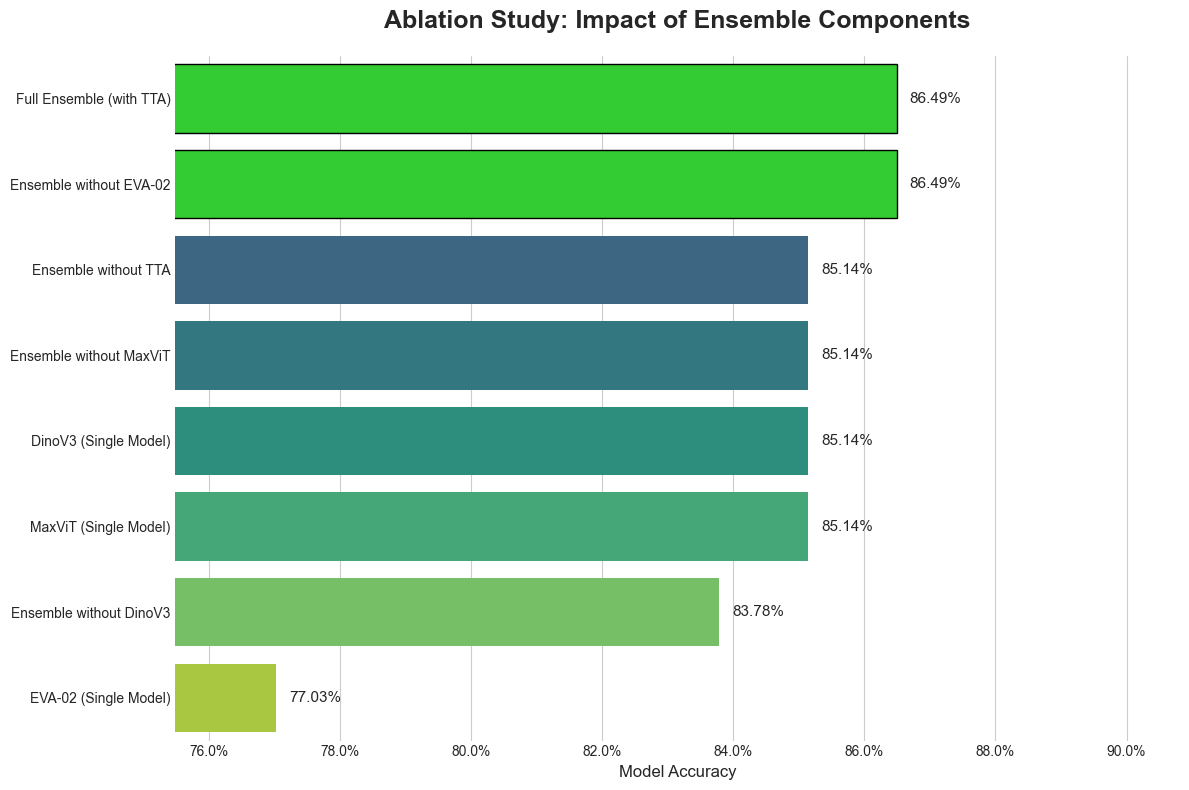

Plotting complete.


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_ablation_results(results_dict):
    """
    Generates a professional bar chart to visualize the ablation study results.
    
    Args:
        results_dict (dict): A dictionary with configuration names as keys
                             and accuracy scores as values.
    """
    # --- Data Preparation ---
    # Convert the dictionary to a pandas DataFrame for easy plotting
    df = pd.DataFrame(list(results_dict.items()), columns=['Configuration', 'Accuracy'])
    
    # Sort the DataFrame by accuracy in descending order
    df = df.sort_values('Accuracy', ascending=False).reset_index(drop=True)
    
    # --- Plotting ---
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Create the horizontal bar plot
    bars = sns.barplot(x='Accuracy', y='Configuration', data=df, palette='viridis', ax=ax)
    
    # --- Aesthetics and Labels ---
    ax.set_title('Ablation Study: Impact of Ensemble Components', fontsize=18, fontweight='bold', pad=20)
    ax.set_xlabel('Model Accuracy', fontsize=12)
    ax.set_ylabel('') # The y-axis labels are clear enough
    
    # Set the x-axis to be formatted as percentages
    # Dynamically set xlim based on data for better visualization
    min_acc = df['Accuracy'].min()
    max_acc = df['Accuracy'].max()
    ax.set_xlim(left=min_acc * 0.98, right=max_acc * 1.05) 
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.1%}'))
    
    # Add accuracy values as text labels on each bar
    for bar in bars.patches:
        width = bar.get_width()
        ax.text(
            width + 0.002, # Position the text slightly to the right of the bar
            bar.get_y() + bar.get_height() / 2,
            f'{width:.2%}', # Format text as percentage
            va='center', 
            ha='left',
            fontsize=11
        )
        
    # Highlight all bars that match the best performance
    top_accuracy = df['Accuracy'].max()
    for i, bar in enumerate(bars.patches):
        if df['Accuracy'][i] >= top_accuracy:
            bar.set_facecolor('#33CC33') # Green for the best
            bar.set_edgecolor('black')

    sns.despine(left=True, bottom=True)
    plt.tight_layout()
    plt.show()

# =============================================================================
# MAIN EXECUTION FOR PLOTTING
# =============================================================================
if __name__ == "__main__":
    # --- Updated with the final results from your last run ---
    ablation_results = {
        'Full Ensemble (with TTA)': 0.8649,
        'Ensemble without EVA-02': 0.8649,
        'Ensemble without TTA': 0.8514,
        'Ensemble without MaxViT': 0.8514,
        'DinoV3 (Single Model)': 0.8514,
        'MaxViT (Single Model)': 0.8514,
        'Ensemble without DinoV3': 0.8378,
        'EVA-02 (Single Model)': 0.7703,
    }
    
    print("Generating ablation study visualization...")
    plot_ablation_results(ablation_results)
    print("Plotting complete.")

